#  Summary of what this capstone will, and may accomplish

* Scrape data from indeed, and return job postings
* properly format location, title, requirements (location done, 
* analyze what words and requirements occur the most
* Determine the quality of each job posting (how generic does it sound, and how common are the phrases that they are using) - this is important, but needs a bit of refinement
* Compare correlation between words used and position

Not required, but would be nice to implement
* add input to allow users to specifiy the cities to look at
* add a map to visualize how many postings there are in each city 

In [1]:
# Basic imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
job_data = pd.read_csv('data/dc_indeed.csv', index_col=False)
job_data.drop(['Unnamed: 0'], 1, inplace=True)

In [3]:
# Let's check up on the size of our dataframe
job_data.shape

(2413, 7)

In [4]:
# Preview the data
job_data

,Title,Location,Company,Salary,Synopsis,Query,Metro
0,Intelligence Analyst - Entry/Mid-Level,None,National Security Agency,"\r\n $45,972 - $73,105 a year",Entry is with a hi...,data+analyst,washington+dc
1,Data Analyst,None,Callahan & Associates,None,Hands on experienc...,data+analyst,washington+dc
2,Business Intelligence Analyst,None,Washington Metropolitan Area Transit A...,None,"Data processing, data warehousing, and databas...",data+analyst,washington+dc
3,Product Modeling Analyst,None,GEICO,None,Statistical Modeli...,data+analyst,washington+dc
4,Data Analyst,None,Chenega Corporation,None,Perform data entry...,data+analyst,washington+dc
5,Health Interventions and Claims Data Analyst,"Washington, DC 20007 (Georgetown area)",Innovation Center for Biomedical Infor...,None,We are working on applying data sc...,data+analyst,washington+dc
6,Data Analyst 1 - Petroleum Supply,"Washington, DC 20585",IMG Crown Energy Services Joint Venture,"\r\n $40,000 - $45,000 a year",Supporting the data validation tea...,data+analyst,washington+dc
7,Data Fellowship (Spring 2018),"Alexandria, VA",Echelon Insights,"\r\n $1,000 a month",Fellows with proven abilities in t...,data+analyst,washington+dc
8,MS Excel Data Analyst F32711,"Washington, DC 20260 (South West area)",SyApps LLC,None,Analyzing all types of data sets. ...,data+analyst,washington+dc
9,Data Analyst 1,"Washington, DC 20585",IMG Crown Energy Services Joint Venture,"\r\n $42,000 - $45,000 a year",Reviews data edits to ensure accur...,data+analyst,washington+dc


In [5]:
# Doing some data cleaning
for i, row in job_data.iterrows():
    
    # Clean up location column to format 'city, state'
    (job_data['Location'][i]) = ' '.join((job_data['Location'][i]).split(' ', 2)[:2]) 
    
    # Clean up summary column (Better, but doesn't completely remove all whitespace)
    (job_data['Synopsis'][i]) = (job_data['Synopsis'][i]).strip()

In [6]:
# Print number of unique categories for all non-numerical columns
job_data.select_dtypes(include=['object']).nunique()

Title       132
Location     35
Company     170
Salary       58
Synopsis    321
Query         3
Metro         1
dtype: int64

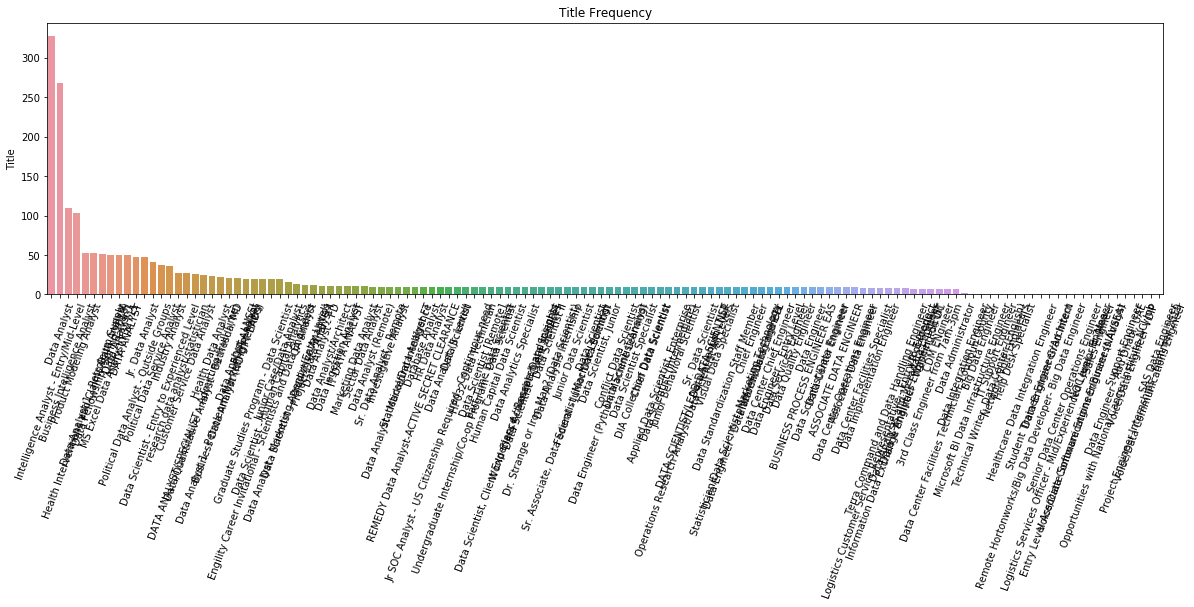

In [7]:
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Title Frequency')

sns.barplot(job_data['Title'].unique(), job_data['Title'].value_counts(), data=job_data)

# Data Visualization

In [8]:
# Print out unique job titles and frequencies
job_data['Title'].value_counts()

Data Analyst                                                    328
Data Scientist                                                  268
Engility Career Invitational - Scientists and Data Engineers    109
Data Engineer                                                   103
Graduate Studies Program - Data Scientist                        53
Data Scientist — Predictive Analytics                            52
Data Engineer – Entry Level                                      51
Data Analytics Specialist                                        50
Data Engineer - Data Warehousing and ETL                         50
Platform/Data Engineer                                           50
Business Intelligence Analyst                                    48
Industry Analyst                                                 48
Data Scientist - Entry to Experienced Level                      41
Undergraduate Internship/Co-op Program - Data Scientist          37
Data Center Engineer                            

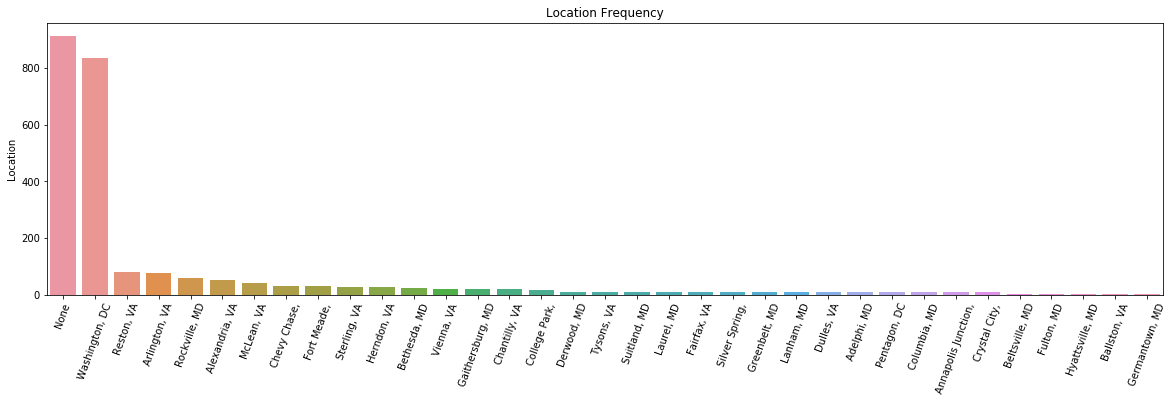

In [9]:
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Location Frequency')
x = job_data['Location'].value_counts().index.tolist()
y = job_data['Location'].value_counts()

sns.barplot(x, y, data=job_data)

In [10]:
location_data = pd.DataFrame()
location_data['Location'] = (job_data['Location'].value_counts().index.tolist())
location_data['Count'] = job_data['Location'].value_counts()

location_data

,Location,Count
0,None,NaN
1,"Washington, DC",NaN
2,"Reston, VA",NaN
3,"Arlington, VA",NaN
4,"Rockville, MD",NaN
5,"Alexandria, VA",NaN
6,"McLean, VA",NaN
7,"Chevy Chase,",NaN
8,"Fort Meade,",NaN
9,"Sterling, VA",NaN


In [11]:
# Attempt at creating a map with location and frequency, 
# the above dataframe needs to be fixed first

# location_data['Location'] = (DC_data['Location'].value_counts().index.tolist())
# location_data['Count'] = DC_data['Location'].value_counts()

# layout = dict(
#         title = '2014 US city populations<br>(Click legend to toggle traces)',
#         showlegend = True,
#         geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
#             showland = True,
#             landcolor = 'rgb(217, 217, 217)',
#             subunitwidth=1,
#             countrywidth=1,
#             subunitcolor="rgb(255, 255, 255)",
#             countrycolor="rgb(255, 255, 255)"
#         ),
#     )

# fig = go.Figure(data=location_data, layout=layout)
# py.iplot(fig, validate=False, filename='d3-bubble-map-populations')

In [12]:
# View sample job descriptions
pd.options.display.max_colwidth = 200
job_data['Synopsis'].head(10)

0      Entry is with a high school diploma or GED plus 7 years of relevant experience, or an Associate's degree plus 5 years of relevant experience, or a Bachelor's...
1                     Hands on experience as a data analyst. Maintain data documentation. Assist on projects related to data collection systems, data analytics etc....
2                 Data processing, data warehousing, and database design. Data cleansing, standardization, un-duplication; Performs data evaluation and integration;...
3                     Statistical Modeling Analyst. Our GEICO Statistical Modeling Analysts earn a starting annual salary between the mid-$60,000s - $70,000 / year....
4         Perform data entry and metadata entry for electronic documents. Assist Analyst or Government Official in obtaining/collecting all documents/information to...
5    We are working on applying data science and predictive analytics tools and methods to analyze health claims data (and potentially electronic health records

# Text Cleaning

In [13]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [14]:
# Remove annoying punctuation from the articles
job_data['Synopsis'] = job_data.Synopsis.map(lambda x: text_cleaner(str(x)))
job_data['Synopsis'].head()

0    Entry is with a high school diploma or GED plus 7 years of relevant experience, or an Associate's degree plus 5 years of relevant experience, or a Bachelor's...
1                   Hands on experience as a data analyst. Maintain data documentation. Assist on projects related to data collection systems, data analytics etc....
2               Data processing, data warehousing, and database design. Data cleansing, standardization, un-duplication; Performs data evaluation and integration;...
3                   Statistical Modeling Analyst. Our GEICO Statistical Modeling Analysts earn a starting annual salary between the mid-$60,000s - $70,000 / year....
4       Perform data entry and metadata entry for electronic documents. Assist Analyst or Government Official in obtaining/collecting all documents/information to...
Name: Synopsis, dtype: object

# Natural Language Processing

In [15]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for summary in job_data['Synopsis']:
    summary = lemmatizer.lemmatize(summary)

In [16]:
# Identify predictor and target variables
X = job_data['Synopsis']
y = job_data['Title']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf vectorizer

In [17]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=5, 
                             max_features=150, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

Number of features: 150


### Spacy

In [18]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

# Create dataframe with count of adverbs, verbs, nouns, and adjectives
X_count = pd.DataFrame(data=X_train_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_count.columns[1:5]:
    X_count[column] = X_count[column] / X_count['sent_length']

# Normalize X_count
X_counter = normalize(X_count.drop('BOW',axis=1))
X_counter  = pd.DataFrame(data=X_counter)

In [19]:
# Combine tf-idf matrix and phrase count matrix
features = pd.concat([X_counter,X_normal], ignore_index=False, axis=1)
features.head()

,0,1,2,3,4,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.000000,0.005859,0.004883,0.000977,0.999970,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210345,0.0,0.000000
1,0.001479,0.005917,0.013312,0.000000,0.999893,0.0,0.0,0.0,0.0,0.277001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.000000,0.002378,0.007134,0.005945,0.999954,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0.000000,0.003472,0.017358,0.000000,0.999843,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.577685
4,0.000000,0.003826,0.012754,0.001275,0.999911,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300544,0.0,0.000000


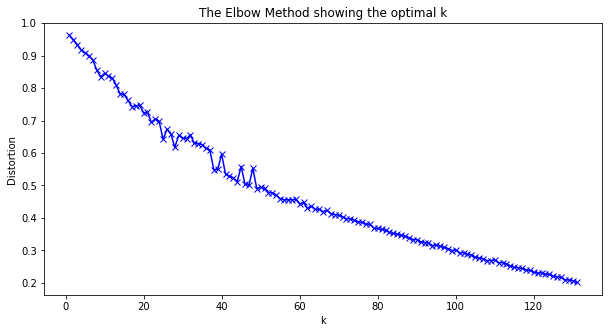

In [20]:
# Size of graph
plt.rcParams['figure.figsize'] = [10,5]

# k means determine k
distortions = []
K = range(1,job_data['Title'].nunique())
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features)
    kmeanModel.fit(features)
    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
# Calulate predicted values
kmeans = KMeans(n_clusters=9, init='k-means++', random_state=42, n_init=20)
y_pred1 = kmeans.fit_predict(features)

pd.crosstab(y_train, y_pred1)

col_0,0,1,2,3,4,5,6,7,8
Title,,,,,,,,,
3rd Class Engineer from 7am-3pm,6,0,0,0,0,0,0,0,0
ASSOCIATE DATA ENGINEER,1,8,0,0,0,0,0,0,0
"Applied Data Scientist, Enterprise",6,0,0,0,0,0,0,0,0
"Associate, Data Engineer",6,0,0,0,0,0,0,0,0
BUSINESS PROCESS ENGINEER EAS,1,0,0,0,0,0,0,0,0
Big Data Engineer,8,0,0,0,0,0,0,0,0
Business Data Analyst (NO OPT EADs),1,0,0,4,0,0,0,0,0
Business Intelligence Analyst,2,0,0,0,0,0,0,38,0
CDM ENgineer,10,0,0,0,0,0,0,0,0


In [22]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred1)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred1, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.08179916
Silhouette Score: 0.135621


### Tf-idf Matrix

In [23]:
# Creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(job_data['Synopsis'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=job_data['Query'].nunique()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [25]:
from sklearn.decomposition import NMF

# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nnmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [26]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                LSA              NNMF
0       data 245.28         data 18.7
0  experience 69.99         work 4.88
0     analyst 65.28      analyst 4.74
0   analytics 59.42   experience 4.58
0    engineer 56.69     engineer 4.52
0        work 50.93    scientists 3.6
0   scientists 49.4    scientist 3.51
0        team 45.62         team 3.42
0   engineers 44.56   collection 3.24
0       years 42.12  integration 2.95
Topic 1:
                 LSA               NNMF
1      experts 32.01       hosting 9.57
1    engineers 29.94        career 9.57
1     engility 29.92  invitational 9.57
1   scientists 28.76      engility 9.52
1        career 27.0        experts 9.3
1  invitational 27.0     technical 8.45
1       hosting 27.0        effects 8.3
1    technical 25.66        weapons 8.3
1  researchers 22.66       involved 8.3
1       effects 22.3     engineers 8.28
Topic 2:
                LSA             NNMF
2   analytics 39.29  analytics 11.92
2    learning 25.67        data 8.63
2   

In [27]:
job_data['Query'].nunique()

3